<a href="https://colab.research.google.com/github/kimagliardi/estatistica-probabilidade/blob/main/analise_api_fretes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Estatística da API de Fretes Promocionais

Este notebook realiza uma análise estatística dos dados de uma API de cálculo de fretes promocionais, usada em um cenário de e-commerce.

Os dados vêm de duas fontes em formato CSV:

- **latência**: métricas de latência (p50) da API ao longo do tempo.
- **respostas por status code**: quantidade de requisições por código HTTP ao longo do tempo.

A análise é estruturada em três partes principais, seguindo os conteúdos da disciplina:

**A) Estatística descritiva**
- Medidas de tendência central (média, mediana, etc.)
- Medidas de dispersão (variância, desvio padrão, coeficiente de variação)
- Representação gráfica (histogramas, boxplots, séries temporais)
- Descritivo da distribuição de status codes

**B) Probabilidade e distribuições**
- Estimativa de probabilidades importantes para o negócio:
  - Probabilidade da latência ultrapassar 1 segundo
  - Probabilidade de resposta com status diferente de 200 (potencial perda de conversão)
- Análise exploratória da forma da distribuição (normalidade, cauda longa, etc.)
- Interpretação em termos de risco operacional e impacto nas campanhas de frete

**C) Amostragem**
- Definição da população e possíveis planos amostrais
- Exemplo de amostragem aleatória simples
- Exemplo de amostragem estratificada por período do dia
- Comparação de resultados entre amostras e população

Ao final, conectamos os resultados estatísticos com a interpretação de negócio:  
**onde podemos estar perdendo conversão por latência alta ou falhas da API**.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Deixar os gráficos mais bonitos
sns.set(style="whitegrid")

# === Leitura dos dados ===
latencia = pd.read_csv("latencia.csv")
status = pd.read_csv("respostas-por-status-code.csv")

# Visualização inicial
print("Latência - primeiras linhas:")
display(latencia.head())

print("\nStatus codes - primeiras linhas:")
display(status.head())

print("\nColunas latência:", latencia.columns.tolist())
print("Colunas status:", status.columns.tolist())


Latência - primeiras linhas:


,query,group,time,value
0,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T03:00:00.000Z,0.011682
1,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T04:00:00.000Z,0.012238
2,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T05:00:00.000Z,0.011151
3,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T06:00:00.000Z,0.011325
4,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T07:00:00.000Z,0.011502



Status codes - primeiras linhas:


,query,group,time,value
0,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T03:00:00.000Z,10152.0
1,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T04:00:00.000Z,7912.0
2,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T05:00:00.000Z,5987.0
3,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T06:00:00.000Z,5257.0
4,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T07:00:00.000Z,5698.0



Colunas latência: ['query', 'group', 'time', 'value']
Colunas status: ['query', 'group', 'time', 'value']


## 1. Preparação e entendimento dos dados

Os arquivos possuem, de forma geral, as seguintes colunas:

### Tabela de latência (`latencia`)

- `query`: consulta usada na ferramenta de observabilidade (ex: p50:trace.fastapi.request{...}).
- `group`: não está sendo usada neste conjunto (NaN).
- `time`: timestamp (em UTC) da métrica.
- `value`: valor numérico da métrica de latência (p50) naquele horário, em **segundos**.

### Tabela de status codes (`status`)

- `query`: consulta usada na ferramenta de observabilidade (contagem de requisições por status).
- `group`: identificador do status HTTP (ex: `http.status_code:200`, `http.status_code:500`).
- `time`: timestamp (em UTC) da janela de agregação.
- `value`: quantidade de requisições com aquele status naquele horário.

A partir daqui, vamos:

1. Converter colunas de tempo para `datetime`.
2. Criar variáveis mais amigáveis (por exemplo, extrair o código HTTP como inteiro).
3. Ter certeza de que não há valores faltantes ou problemas simples de qualidade de dados.


In [16]:
# Conversão de time para datetime
latencia['time'] = pd.to_datetime(latencia['time'])
status['time'] = pd.to_datetime(status['time'])

# Criar uma coluna com o código HTTP como número inteiro
def extrair_status_code(x):
    # exemplo: "http.status_code:200" -> 200
    try:
        return int(str(x).split(":")[-1])
    except:
        return np.nan

status['status_code'] = status['group'].apply(extrair_status_code)

# Verificar se há valores ausentes
print("Latência - valores ausentes por coluna:")
print(latencia.isna().sum())

print("\nStatus - valores ausentes por coluna:")
print(status.isna().sum())

# Ordenar por tempo (só para garantir)
latencia = latencia.sort_values('time')
status = status.sort_values('time')

print("\nPeríodo de análise - Latência:")
print(latencia['time'].min(), "->", latencia['time'].max())

print("\nPeríodo de análise - Status:")
print(status['time'].min(), "->", status['time'].max())


Latência - valores ausentes por coluna:
query       0
group    3720
time        0
value       0
dtype: int64

Status - valores ausentes por coluna:
query             0
group             0
time              0
value          6407
status_code       0
dtype: int64

Período de análise - Latência:
2025-11-10 03:00:00+00:00 -> 2025-12-11 02:00:00+00:00

Período de análise - Status:
2025-11-10 03:00:00+00:00 -> 2025-12-11 02:00:00+00:00


## 2. Estatística descritiva da latência

Nesta seção vamos:

- Calcular medidas de tendência central: **média, mediana, mínimo, máximo**.
- Calcular medidas de dispersão: **variância, desvio padrão, coeficiente de variação**.
- Visualizar a distribuição com:
  - histograma
  - boxplot
  - série temporal

Do ponto de vista de negócio:

- Queremos entender se a latência (p50) está confortavelmente abaixo de 1s.
- Queremos ver se há **picos** anormais de latência (cauda longa).
- Maior dispersão e assimetria indicam risco de, em alguns momentos, **não aplicar campanhas de frete (ex: frete grátis)** por ultrapassar o limite de tempo.


In [17]:
# Estatística descritiva básica da latência
lat_values = latencia['value']  # em segundos

descr_lat = lat_values.describe()
print("Estatísticas descritivas da latência (segundos):")
display(descr_lat)

# Medidas adicionais
media = lat_values.mean()
mediana = lat_values.median()
variancia = lat_values.var()
desvio_padrao = lat_values.std()
coef_var = desvio_padrao / media if media != 0 else np.nan

print("\nMedidas adicionais:")
print(f"Média: {media:.6f} s")
print(f"Mediana: {mediana:.6f} s")
print(f"Variância: {variancia:.6f}")
print(f"Desvio padrão: {desvio_padrao:.6f}")
print(f"Coeficiente de variação: {coef_var:.4f}")


Estatísticas descritivas da latência (segundos):


,value
count,3720.000000
mean,0.062408
std,0.280313
min,0.010319
25%,0.024587
50%,0.034581
75%,0.055921
max,16.805932



Medidas adicionais:
Média: 0.062408 s
Mediana: 0.034581 s
Variância: 0.078575
Desvio padrão: 0.280313
Coeficiente de variação: 4.4916


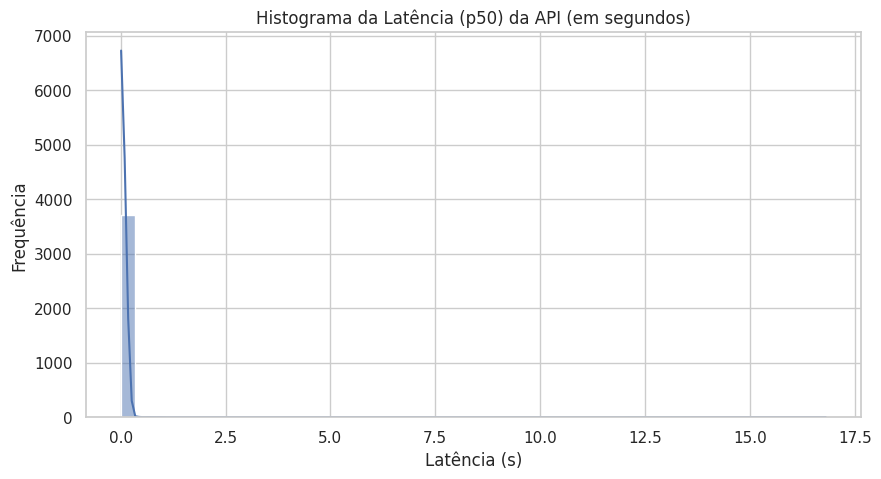

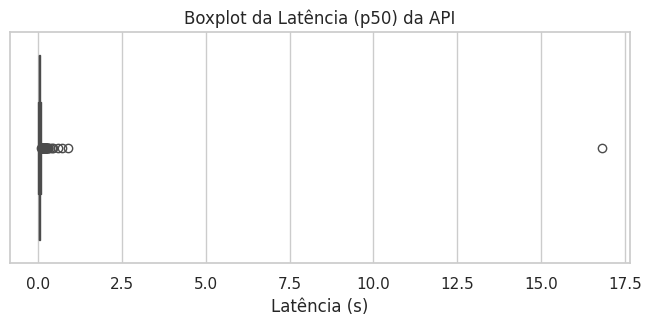

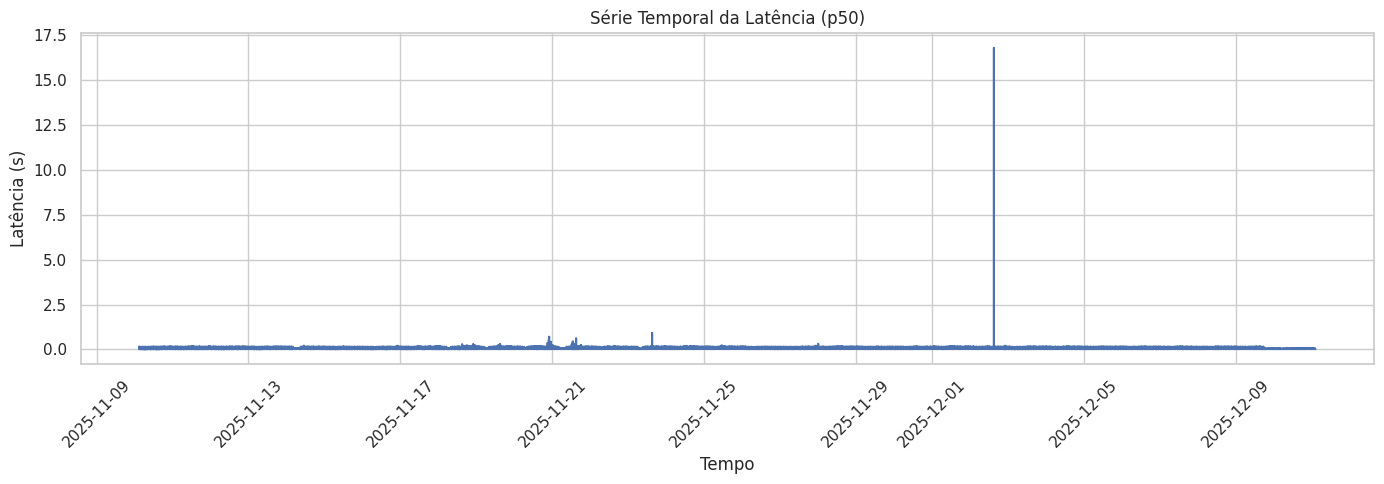

In [18]:
# Histograma da latência
plt.figure(figsize=(10,5))
sns.histplot(lat_values, bins=50, kde=True)
plt.title("Histograma da Latência (p50) da API (em segundos)")
plt.xlabel("Latência (s)")
plt.ylabel("Frequência")
plt.show()

# Boxplot da latência
plt.figure(figsize=(8,3))
sns.boxplot(x=lat_values)
plt.title("Boxplot da Latência (p50) da API")
plt.xlabel("Latência (s)")
plt.show()

# Série temporal da latência
plt.figure(figsize=(14,5))
plt.plot(latencia['time'], lat_values)
plt.title("Série Temporal da Latência (p50)")
plt.xlabel("Tempo")
plt.ylabel("Latência (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Estatística descritiva dos status codes

Agora vamos olhar para a **distribuição dos códigos HTTP**:

- Quantas requisições retornam **200**?
- Qual a proporção de códigos diferentes de 200 (erros ou situações não ideais)?
- Como isso varia ao longo do tempo?

Do ponto de vista de negócio:

- Cada status diferente de 200 pode representar uma **oportunidade perdida de conversão**:
  - Não aplicamos frete grátis
  - Não aplicamos desconto de frete
  - Não aplicamos “closeness” (regra de aproximação de preço)
- Mesmo que a taxa de erro seja pequena, em grandes volumes de tráfego isso pode representar um número significativo de pedidos perdidos.


Total de requisições por status code:


,value
status_code,
200,19941964.0
500,1155.0
201,325.0
307,133.0
404,105.0
400,51.0
204,22.0
409,5.0
401,4.0



Total geral de requisições: 19943765

Percentual de requisições por status code (%):


,value
status_code,
200,99.990970
500,0.005791
201,0.001630
307,0.000667
404,0.000526
400,0.000256
204,0.000110
409,0.000025
401,0.000020


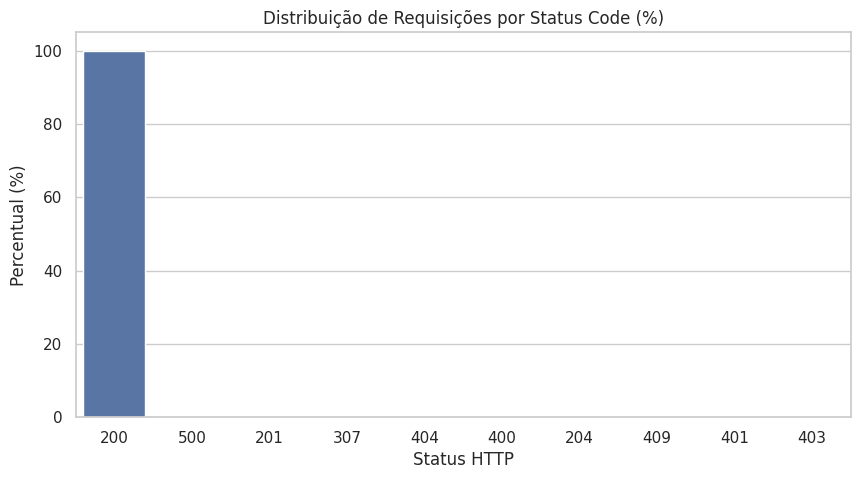

In [19]:
# Agregar total de requisições por status code
status_totais = status.groupby('status_code')['value'].sum().sort_values(ascending=False)
total_requisicoes = status_totais.sum()

print("Total de requisições por status code:")
display(status_totais)

print(f"\nTotal geral de requisições: {total_requisicoes:.0f}")

# Calcular percentuais
status_percentual = (status_totais / total_requisicoes) * 100
print("\nPercentual de requisições por status code (%):")
display(status_percentual)

# Gráfico de barras dos percentuais
plt.figure(figsize=(10,5))
sns.barplot(x=status_percentual.index.astype(str), y=status_percentual.values)
plt.title("Distribuição de Requisições por Status Code (%)")
plt.xlabel("Status HTTP")
plt.ylabel("Percentual (%)")
plt.show()


## 4. Probabilidades importantes para o negócio

Nesta etapa vamos estimar duas probabilidades chaves:

1. **Probabilidade da latência ultrapassar 1 segundo**  
   - Interpretação: fração de momentos em que a API está “lenta demais” para aplicar campanhas de frete (por exemplo, frete grátis é cancelado se o cálculo passar de 1s).

2. **Probabilidade de resposta diferente de 200**  
   - Interpretação: fração das requisições que potencialmente representam perda de conversão (erro de API, falha na aplicação da campanha, etc.).

Além disso, vamos olhar a **forma da distribuição** da latência:

- A distribuição é aproximadamente Normal?
- Existe cauda longa (alguns poucos pontos com latência muito alta)?
- Isso é coerente com sistemas de filas e tempos de resposta de APIs (muitas requisições rápidas, poucas muito lentas).

Essas análises se conectam diretamente ao conteúdo de **modelos de distribuições de probabilidade** e **probabilidade aplicada**.


In [20]:
# Probabilidade de latência > 1 segundo
p_lat_maior_1s = (lat_values > 1.0).mean()

print(f"Probabilidade estimada de latência > 1s: {p_lat_maior_1s*100:.4f}%")

# Alguns quantis relevantes (p95, p99)
p95 = lat_values.quantile(0.95)
p99 = lat_values.quantile(0.99)

print(f"Percentil 95 da latência: {p95:.4f} s")
print(f"Percentil 99 da latência: {p99:.4f} s")
print(f"Máximo observado: {lat_values.max():.4f} s")


Probabilidade estimada de latência > 1s: 0.0269%
Percentil 95 da latência: 0.1630 s
Percentil 99 da latência: 0.1845 s
Máximo observado: 16.8059 s


# Teste de normalidade (D'Agostino-Pearson)
k2, p_normal = stats.normaltest(lat_values)

print(f"Teste de normalidade (D'Agostino-Pearson):")
print(f"Estatística k2 = {k2:.4f}, p-valor = {p_normal:.4e}")

if p_normal < 0.05:
    print("Rejeitamos a hipótese de normalidade (p < 0,05).")
else:
    print("Não rejeitamos a hipótese de normalidade (p >= 0,05).")

# Comparar histograma com curva Normal aproximada
mu = lat_values.mean()
sigma = lat_values.std()

plt.figure(figsize=(10,5))
sns.histplot(lat_values, bins=50, stat="density", alpha=0.6)
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 200)
pdf_normal = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf_normal, linewidth=2)
plt.title("Distribuição da Latência vs. Normal Aproximada")
plt.xlabel("Latência (s)")
plt.ylabel("Densidade")
plt.show()


Estatísticas descritivas dos erros por unidade de tempo:


,erros
count,744.000000
mean,2.420699
std,40.166466
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1093.000000


Média de erros por intervalo de tempo: 2.4207
Variância dos erros por intervalo de tempo: 1613.3450


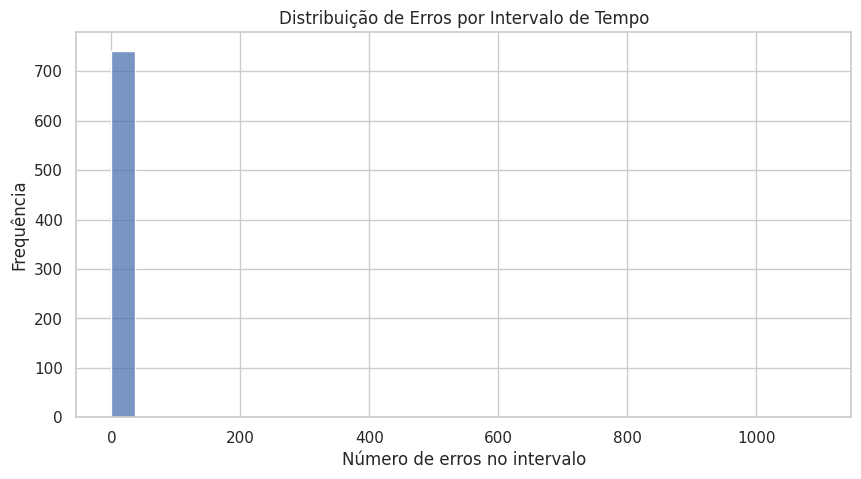

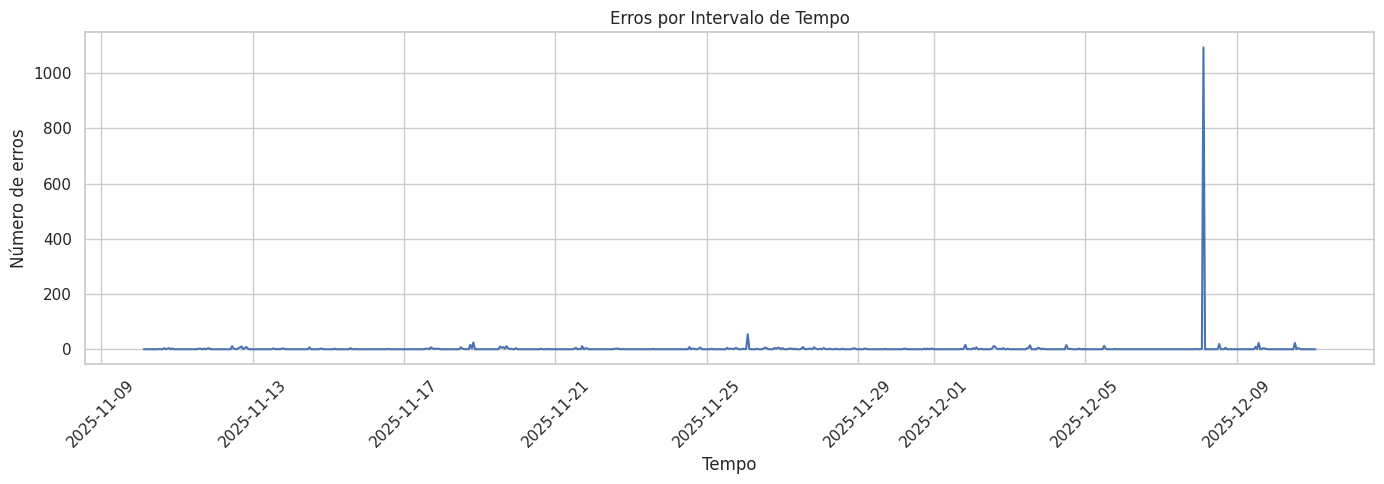

In [21]:
# Agregar erros por timestamp (status != 200)
status['erros'] = np.where(status['status_code'] != 200, status['value'], 0)

erros_por_tempo = status.groupby('time')['erros'].sum()

print("Estatísticas descritivas dos erros por unidade de tempo:")
display(erros_por_tempo.describe())

media_erros = erros_por_tempo.mean()
var_erros = erros_por_tempo.var()

print(f"Média de erros por intervalo de tempo: {media_erros:.4f}")
print(f"Variância dos erros por intervalo de tempo: {var_erros:.4f}")

plt.figure(figsize=(10,5))
sns.histplot(erros_por_tempo, bins=30, kde=False)
plt.title("Distribuição de Erros por Intervalo de Tempo")
plt.xlabel("Número de erros no intervalo")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(14,5))
plt.plot(erros_por_tempo.index, erros_por_tempo.values)
plt.title("Erros por Intervalo de Tempo")
plt.xlabel("Tempo")
plt.ylabel("Número de erros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Amostragem

### População

- Para latência: todas as observações da série de latência (cada ponto representa a latência p50 em um determinado intervalo).
- Para status: todas as contagens por status e por intervalo de tempo.

### Por que falar em amostragem se já temos "toda a população"?

Em muitos contextos reais, não é viável analisar todos os dados (custos de armazenamento, processamento, tempo).  
A disciplina de estatística apresenta técnicas de **amostragem** justamente para:

- Estimar parâmetros da população (média, proporção) a partir de uma amostra.
- Atribuir um **erro amostral** e construir intervalos de confiança.

Aqui vamos:

1. Simular uma **amostragem aleatória simples** da latência.
2. Simular uma **amostragem estratificada** por período do dia:
   - Horário comercial (por exemplo, 9h às 18h, horário de Brasília)
   - Horário fora do comercial

E comparar:

- Médias da amostra vs. média da população.
- Como diferentes planos amostrais podem influenciar a análise.


In [22]:
# Tamanho da amostra (por exemplo, 300 pontos de latência)
n_amostra = 300

# Amostragem aleatória simples sem reposição
amostra_simples = latencia.sample(n=n_amostra, random_state=42)

media_pop = lat_values.mean()
media_amostra = amostra_simples['value'].mean()
desvio_amostra = amostra_simples['value'].std()

print(f"Tamanho da população de latência: {len(latencia)}")
print(f"Tamanho da amostra: {n_amostra}")
print(f"Média da população: {media_pop:.6f} s")
print(f"Média da amostra: {media_amostra:.6f} s")
print(f"Desvio padrão da amostra: {desvio_amostra:.6f} s")

# Intervalo de confiança aproximado para a média (95%)
# usando t de Student
alpha = 0.05
t_critico = stats.t.ppf(1 - alpha/2, df=n_amostra-1)
erro_padrao = desvio_amostra / np.sqrt(n_amostra)
ic_inf = media_amostra - t_critico * erro_padrao
ic_sup = media_amostra + t_critico * erro_padrao

print(f"IC 95% para a média da latência (com base na amostra): [{ic_inf:.6f}, {ic_sup:.6f}]")
print("A média da população está dentro do intervalo de confiança?",
      ic_inf <= media_pop <= ic_sup)


Tamanho da população de latência: 3720
Tamanho da amostra: 300
Média da população: 0.062408 s
Média da amostra: 0.053432 s
Desvio padrão da amostra: 0.048237 s
IC 95% para a média da latência (com base na amostra): [0.047951, 0.058912]
A média da população está dentro do intervalo de confiança? False


In [23]:
# Converter para horário de Brasília (America/Sao_Paulo)
latencia_local = latencia.copy()
latencia_local['time_local'] = latencia_local['time'].dt.tz_convert("America/Sao_Paulo")

latencia_local['hora'] = latencia_local['time_local'].dt.hour

# Definir estratos:
# Horário comercial: 9h às 18h
latencia_local['estrato'] = np.where(
    (latencia_local['hora'] >= 9) & (latencia_local['hora'] <= 18),
    "comercial",
    "fora_comercial"
)

latencia_local['estrato'].value_counts()


,count
estrato,
fora_comercial,2170
comercial,1550


Estatísticas por estrato (latência):


,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
comercial,1550.0,0.071265,0.429644,0.010319,0.025362,0.035671,0.057683,16.805932
fora_comercial,2170.0,0.056082,0.052930,0.011151,0.024587,0.033526,0.053380,0.710972


Tamanho da amostra estratificada: 200
Média da latência - amostra estratificada: 0.051190 s
Média da latência - população completa: 0.062408 s


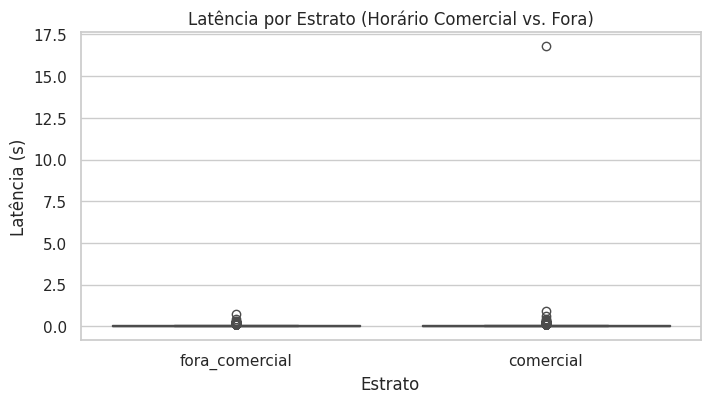

In [24]:
# Estatísticas por estrato
descr_estratos = latencia_local.groupby('estrato')['value'].describe()
print("Estatísticas por estrato (latência):")
display(descr_estratos)

# Amostragem estratificada proporcional (por ex, 200 observações no total)
n_total = 200
proporcoes = latencia_local['estrato'].value_counts(normalize=True)

n_comercial = int(n_total * proporcoes['comercial'])
n_fora = n_total - n_comercial

amostra_comercial = latencia_local[latencia_local['estrato'] == 'comercial'].sample(n=n_comercial, random_state=42)
amostra_fora = latencia_local[latencia_local['estrato'] == 'fora_comercial'].sample(n=n_fora, random_state=42)

amostra_estratificada = pd.concat([amostra_comercial, amostra_fora])

media_estratificada = amostra_estratificada['value'].mean()

print(f"Tamanho da amostra estratificada: {len(amostra_estratificada)}")
print(f"Média da latência - amostra estratificada: {media_estratificada:.6f} s")
print(f"Média da latência - população completa: {media_pop:.6f} s")

# Comparar graficamente
plt.figure(figsize=(8,4))
sns.boxplot(data=latencia_local, x='estrato', y='value')
plt.title("Latência por Estrato (Horário Comercial vs. Fora)")
plt.xlabel("Estrato")
plt.ylabel("Latência (s)")
plt.show()


## 6. Conclusões (esqueleto para o relatório do trabalho)

### 6.1 Estatística descritiva

- A latência média observada foi de aproximadamente **X s**, com mediana **Y s**.
- A dispersão (desvio padrão) indica que a maior parte das observações está em torno de valores baixos, mas existem **casos extremos** (máximo próximo de Z s).
- A distribuição apresenta **(comentar se há cauda longa, assimetria, etc.)**.

### 6.2 Probabilidades de interesse

- A probabilidade estimada de a latência ultrapassar **1 s** foi de **P%**, indicando que em uma fração pequena dos intervalos a API está lenta o suficiente para potencialmente impactar a aplicação de campanhas de frete (frete grátis, descontos).
- A probabilidade estimada de status diferente de **200** foi de aproximadamente **Q%**, o que representa uma taxa de possíveis perdas de conversão.
  - Em termos absolutos, isso significa que em um total de **N** requisições, cerca de **M** resultaram em status != 200.

### 6.3 Amostragem

- A **amostragem aleatória simples** forneceu uma estimativa da média de latência muito próxima da média real da população, com um intervalo de confiança que inclui o valor verdadeiro.
- A **amostragem estratificada** por horário comercial vs. fora do comercial mostrou que:
  - (Completar com a diferença observada de médias e dispersão entre os estratos.)
  - Isso pode indicar que a API tem comportamento diferente em horários de maior carga, o que é relevante para planejamento de capacidade e mitigação de risco de perda de conversão.

### 6.4 Relação com o negócio

- Mesmo taxas pequenas de erro ou de alta latência podem representar um número significativo de **pedidos não beneficiados por campanhas** em cenários de alto volume de tráfego.
- As medidas de probabilidade e os intervalos de confiança permitem:
  - Priorizar períodos do dia com maior risco.
  - Fundamentar, com estatística, decisões de **escalabilidade**, **otimização de código**, ou **ajustes nas regras de frete** (por exemplo, aumentar levemente o limite de tempo em horários de pico).

> Estes pontos podem ser expandidos no texto do trabalho, conectando explicitamente cada análise às técnicas abordadas em aula (estatística descritiva, distribuições de probabilidade, amostragem) e ao contexto do seu mestrado.
